# Near-term forcing trends

We focus on the 2000-2019 period.

In [15]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as pl
import wquantiles
from matplotlib import rc
import pandas as pd

import h5py

In [2]:
def save_dict_to_hdf5(dic, filename):
    """
    ....
    """
    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents_to_group(h5file, '/', dic)

def recursively_save_dict_contents_to_group(h5file, path, dic):
    """
    ....
    """
    for key, item in dic.items():
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, dict):
            recursively_save_dict_contents_to_group(h5file, path + key + '/', item)
        else:
            raise ValueError('Cannot save %s type'%type(item))

def load_dict_from_hdf5(filename):
    """
    ....
    """
    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/')

def recursively_load_dict_contents_from_group(h5file, path):
    """
    ....
    """
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/')
    return ans

In [3]:
colors = {
    'CMIP6-constrained' : '0.3',
}

ls = {
    'CMIP6-constrained'  : '-',
}

In [4]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [5]:
# load large datafiles calculated previously
ERFari = load_dict_from_hdf5('../data_output/results/ERFari.h5')
ERFaci = load_dict_from_hdf5('../data_output/results/ERFaci.h5')
temp   = load_dict_from_hdf5('../data_output/results/temp.h5')
ks     = load_dict_from_hdf5('../data_output/results/knutti_score.h5')
ohc    = load_dict_from_hdf5('../data_output/results/ohc.h5')
hflux  = load_dict_from_hdf5('../data_output/results/hflux.h5')

In [6]:
expts = ['CMIP6-constrained']

In [7]:
t90 = st.t.ppf(0.95, df=19)

In [8]:
def weighted_percentile(a, w, q):
    if isinstance(q, (list, tuple, np.ndarray)):
        result = []
        for iq in q:
            result.append(wquantiles.quantile(a, w, iq))
    else:
        result = wquantiles.quantile(a, w, q)
    return result

In [9]:
samples = 100000

In [10]:
slopes = np.zeros(samples)
for i in range(samples):
    sl, _,_,_,_ = st.linregress(np.arange(20), ERFari['CMIP6-constrained'][250:270,i]+ERFaci['CMIP6-constrained'][250:270,i])
    slopes[i] = sl

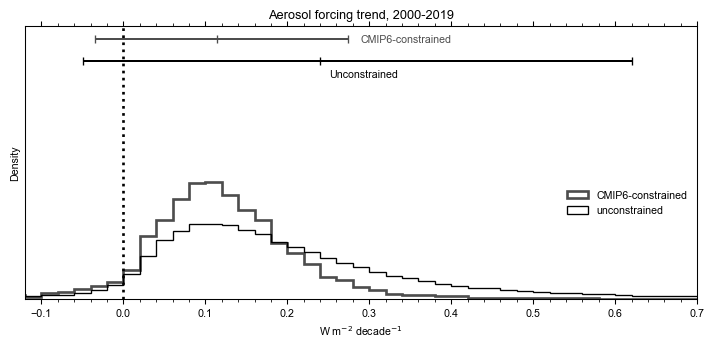

In [11]:
pl.figure(figsize=(19/2.54,9.3/2.54))
pl.hist(slopes * 10, weights=ks['multi']['CMIP6-constrained'], bins=np.arange(-0.6,0.76,0.02), density=True, color=colors['CMIP6-constrained'], lw=2, label='CMIP6-constrained', histtype='step');
pl.hist(slopes * 10, bins=np.arange(-0.6,0.76,0.02), density=True, color='k', label='unconstrained', histtype='step');

pl.plot(np.sum(slopes * 10 * ks['multi']['CMIP6-constrained']), 12, '|', color=colors['CMIP6-constrained'])
#pl.plot(weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50), 12, '|', color=colors['CMIP6-constrained'])
pl.errorbar(
    weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50),
    12,
    xerr=np.array([
        weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50) - weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .05),
        weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .95) - weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], .50)
    ]).reshape((1,2)).T,
    capsize=3, color=colors['CMIP6-constrained']
)
pl.text(0.40, 12, 'CMIP6-constrained', color=colors['CMIP6-constrained'], ha='right', va='center')
pl.plot(np.mean(slopes * 10), 11, '|', color='k')
#pl.plot(np.percentile(slopes * 10, 50), 11, '|', color='k')
pl.errorbar(
    np.percentile(slopes * 10, 50),
    11,
    xerr=np.array([
        np.percentile(slopes * 10, 50) - np.percentile(slopes * 10, 5),
        np.percentile(slopes * 10, 95) - np.percentile(slopes * 10, 50)
    ]).reshape((1,2)).T,
    capsize=3, color='k'
)
pl.text(0.335, 10.4, 'Unconstrained', color='k', ha='right', va='center')
pl.title('Aerosol forcing trend, 2000-2019')
pl.xlabel('W m$^{-2}$ decade$^{-1}$')
pl.ylabel('Density')
pl.yticks([])
pl.axvline(0, ls=':', color='k', lw=2)
pl.legend(frameon=False, loc='lower right', bbox_to_anchor=[1, 0.27]);
pl.xlim(-0.12,0.7)
pl.tight_layout();
pl.savefig('../figures/figure7_2000-2019.png')
pl.savefig('../figures/figure7_2000-2019.pdf')

In [12]:
print(weighted_percentile(slopes * 10, ks['multi']['CMIP6-constrained'], [.05,.95]), np.sum(slopes * 10 * ks['multi']['CMIP6-constrained']))
print(np.percentile(slopes*10, (5,95)), np.mean(slopes*10))

[-0.034226072220599126, 0.2736756006889424] 0.11429911128697476
[-0.04930542  0.62084684] 0.2403688119960853


In [13]:
(slopes * 10).shape

(100000,)

In [14]:
(ks['multi']['CMIP6-constrained']).shape

(100000,)

In [18]:
df = pd.DataFrame(
    data={
        'Rate': slopes*10,
        'Weight': ks['multi']['CMIP6-constrained']
    }
)

In [17]:
ks['multi']['CMIP6-constrained'].sum()

0.9999999999999997

In [19]:
df.to_csv('../data_output/erf_rates_Wm-2dec-1_2000-2019.csv', index=False)